# NFL Database Exploratory Data Analysis (EDA)

## 1. Introduction
- This notebook explores key trends and insights in the NFL database, focusing on team performance, player statistics, and the influence of weather on games.
- Going to start specifically investigating the complete 2023 regular season. 
---
## 2. Data Loading
### 2.1: Load database and notebook settings
- Load necessary modules and nfl_fantasy.db (sqlite) into notebook
### 2.2: Final 2023 Standings
- Organize final standings from 2023 season
### 2.3: Player Statistics from Entire 2023 Regular Season
- Get each players stats from the entire season (Passing Yards, Passing Touchdowns, Receptions, Receiving Yards, Receiving Touchdowns, Carries, Rushing Yards, Rushing Touchdowns)
### 2.4: Team Statistics from Entire 2023 Regular Season
- Summarize each teams offensive and defensive stats for 2023
---
## 3. Exploratory Data Analysis 
### 3.1: Compare Position's Fantasy Success with Team's Success in 2023
- Find potential correlation on how successful team is to success of a QB/RB/WR/TE in fantasy football (Definining success of a team as team's win percentage)
### 3.2: Find what Team Statistics Correlate to Wins/Losses 
Examples:
- Offensive/Defensive Yards
- Offensive/Defensive Points/Points Allowed
- Turnovers
- Penalties
- Sacks


---
## 4. Summary of Findings
- A Quarterback's fantasy performance has a moderately strong correlation to the team's win percentage. Other positions (RB, WR, TE) represent weak or no correlation.

---
## TODO
- [ ] 2.4
- [ ] 3.2


In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os

## 2. Data Collection
### 2.1: Load database and notebook settings

In [2]:
%load_ext sql
conn = sqlite3.connect('..\\nfl_fantasy.db')
cursor = conn.cursor()
%sql sqlite:///C:\Users\Jrdes\Desktop\NFL\NFL-Analytics\nfl_fantasy.db

pd.set_option('display.max_rows', 100) # Increase pandas to display 100 rows max
pd.set_option('display.max_columns', 25)

### 2.2 Final 2023 Standings
Start by charting out each teams wins throughout the season. Helps highlight any losing/winning streaks throughout the season as well as each teams final win total

In [3]:
%%sql results <<

SELECT G.GAME_ID,
       G.GAME_WEEK,
       G.GAME_DATE,
       G.GAME_TYPE,
       G.HOME_TEAM,
       G.AWAY_TEAM,
       T.ABBREVIATION AS WINNING_TEAM
FROM Game G
JOIN Team T
ON G.WINNING_TEAM_ID = T.TEAM_ID
WHERE G.SEASON_ID = 2023
AND G.GAME_TYPE = 'Regular Season';

 * sqlite:///C:\Users\Jrdes\Desktop\NFL\NFL-Analytics\nfl_fantasy.db
Done.
Returning data to local variable results


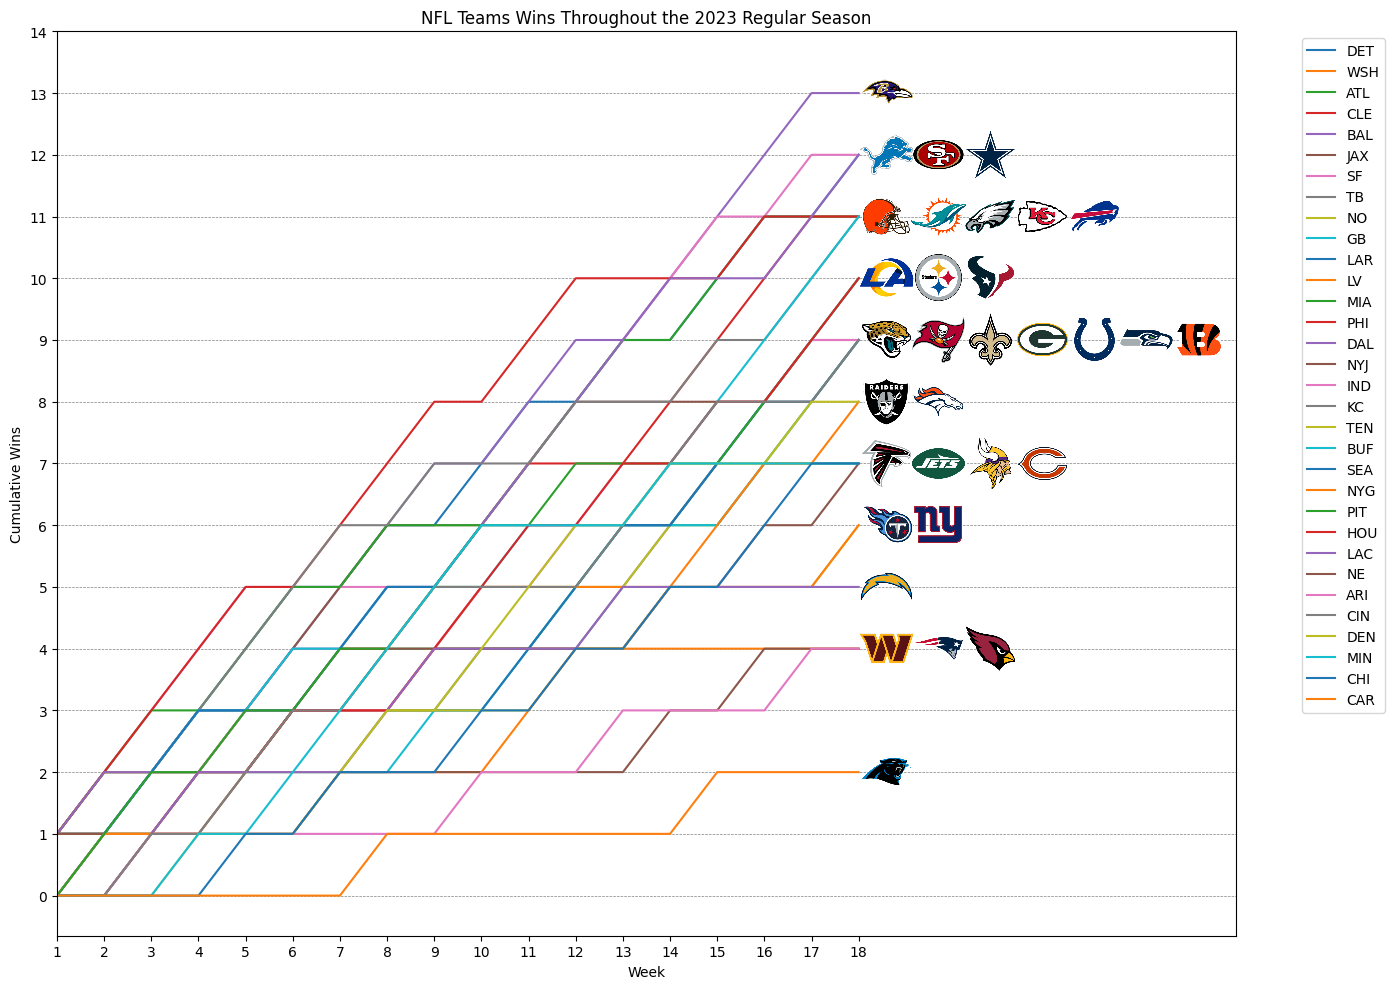

In [4]:
regular_season_results_df = results.DataFrame()

# Remove 'Week' from GAME_WEEK column (e.g., 'Week 1' > 1)
regular_season_results_df['GAME_WEEK'] = regular_season_results_df['GAME_WEEK'].apply(lambda x: int(x.split()[1]))

# Initialize an empty dataframe to store wins per team per week
teams = regular_season_results_df['WINNING_TEAM'].unique()
weeks = regular_season_results_df['GAME_WEEK'].unique()

# Create a wins dictionary
wins_per_week = {team: [0] * len(weeks) for team in teams}

# Count wins per team per week
for week in weeks:
    weekly_games = regular_season_results_df[regular_season_results_df['GAME_WEEK'] == week]
    for team in weekly_games['WINNING_TEAM']:
        wins_per_week[team][week - 1] += 1

# Accumulate the wins week by week (cumulative wins)
for team in teams:
    wins_per_week[team] = pd.Series(wins_per_week[team]).cumsum()

# Function to add image (team logo) next to the final point of each line
def add_logo(ax, img_path, x, y, offset_x):
    img = Image.open(img_path)
    imagebox = OffsetImage(img, zoom=0.14)  # Adjust zoom level for logos
    ab = AnnotationBbox(imagebox, (x + offset_x, y), frameon=False, xybox=(20, 0), xycoords='data',
                        boxcoords="offset points", pad=0)
    ax.add_artist(ab)

# Plotting
fig, ax = plt.subplots(figsize=(14, 10))  # Adjust the figure size for more space

# Add horizontal gridlines for number of wins
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, color='gray')  # Dashed gray lines

logo_offsets = {}
for team, wins in wins_per_week.items():
    ax.plot(weeks, wins, label=team)

    # Get the last week's win count for each team
    last_week = weeks[-1]
    last_win_count = wins.iloc[-1]  # Ensure you're using iloc for the last value

    # Path to the team's logo in 'nfl-logos' folder
    logo_path = f'../../nfl-logos/{team}.png'
    
    if os.path.exists(logo_path):
        # Handle overlapping logos: if another team has the same win count, increase the offset
        if last_win_count in logo_offsets:
            offset_x = logo_offsets[last_win_count] * 1.1  # Increment offset for each same win count
            logo_offsets[last_win_count] += 1
        else:
            offset_x = 0
            logo_offsets[last_win_count] = 1  # Initialize offset for this win count
        
        # Add the logo with an offset
        add_logo(ax, logo_path, last_week, last_win_count, offset_x)

# Adjust x-axis limits to give extra room for logos
plt.xlim(1, weeks[-1] + 8)  # Extending the x-axis by 2 units to the right for logos

# Labeling and formatting the chart
plt.xlabel('Week')
plt.ylabel('Cumulative Wins')
plt.title('NFL Teams Wins Throughout the 2023 Regular Season')
plt.xticks(weeks)  # Set the x-axis ticks to be the weeks
plt.yticks(range(0,15))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.tight_layout()
plt.show()

<b>Organize data into a dataframe holding final 2023 standings</b>

In [5]:
%%sql standings <<
SELECT
    t.ABBREVIATION AS TEAM,
    t.DIVISION AS DIVISION,
    
    -- Total Wins (W)
    SUM(CASE WHEN g.WINNING_TEAM_ID = t.TEAM_ID THEN 1 ELSE 0 END) AS W,
    
    -- Total Losses (L) = Total games played - wins
    SUM(CASE WHEN g.HOME_TEAM_ID = t.TEAM_ID OR g.AWAY_TEAM_ID = t.TEAM_ID THEN 1 ELSE 0 END) 
    - SUM(CASE WHEN g.WINNING_TEAM_ID = t.TEAM_ID THEN 1 ELSE 0 END) AS L,
    
    -- Win Percentage (WIN_PCT)
    ROUND(
        CAST(SUM(CASE WHEN g.WINNING_TEAM_ID = t.TEAM_ID THEN 1 ELSE 0 END) AS REAL)
        / NULLIF(SUM(CASE WHEN g.HOME_TEAM_ID = t.TEAM_ID OR g.AWAY_TEAM_ID = t.TEAM_ID THEN 1 ELSE 0 END), 0), 3) AS WIN_PCT,

    -- Home Record (Wins-Losses)
    SUM(CASE WHEN g.HOME_TEAM_ID = t.TEAM_ID AND g.WINNING_TEAM_ID = t.TEAM_ID THEN 1 ELSE 0 END) 
    || '-' || 
    SUM(CASE WHEN g.HOME_TEAM_ID = t.TEAM_ID AND g.WINNING_TEAM_ID != t.TEAM_ID THEN 1 ELSE 0 END) AS HOME_RECORD,
    
    -- Away Record (Wins-Losses)
    SUM(CASE WHEN g.AWAY_TEAM_ID = t.TEAM_ID AND g.WINNING_TEAM_ID = t.TEAM_ID THEN 1 ELSE 0 END) 
    || '-' || 
    SUM(CASE WHEN g.AWAY_TEAM_ID = t.TEAM_ID AND g.WINNING_TEAM_ID != t.TEAM_ID THEN 1 ELSE 0 END) AS AWAY_RECORD,

    -- Division Record (Wins-Losses)
    SUM(CASE
        -- Division wins
        WHEN g.WINNING_TEAM_ID = t.TEAM_ID AND (
            (g.HOME_TEAM_ID = t.TEAM_ID AND t.DIVISION = at.DIVISION) OR
            (g.AWAY_TEAM_ID = t.TEAM_ID AND t.DIVISION = ht.DIVISION)
        ) THEN 1 ELSE 0 END)
    || '-' ||
    SUM(CASE
        -- Division losses
        WHEN g.WINNING_TEAM_ID != t.TEAM_ID AND (
            (g.HOME_TEAM_ID = t.TEAM_ID AND t.DIVISION = at.DIVISION) OR
            (g.AWAY_TEAM_ID = t.TEAM_ID AND t.DIVISION = ht.DIVISION)
        ) THEN 1 ELSE 0 END) AS DIV_RECORD

FROM
    Team t
    LEFT JOIN Game g ON g.HOME_TEAM_ID = t.TEAM_ID OR g.AWAY_TEAM_ID = t.TEAM_ID
    LEFT JOIN Team ht ON g.HOME_TEAM_ID = ht.TEAM_ID -- Home Team Alias for Division Check
    LEFT JOIN Team at ON g.AWAY_TEAM_ID = at.TEAM_ID -- Away Team Alias for Division Check

-- Filtering for Regular Season and the 2023 Season
WHERE
    g.GAME_TYPE = 'Regular Season'
    AND g.SEASON_ID = '2023'

GROUP BY
    t.ABBREVIATION
ORDER BY
    DIVISION ASC;

 * sqlite:///C:\Users\Jrdes\Desktop\NFL\NFL-Analytics\nfl_fantasy.db
Done.
Returning data to local variable standings


In [6]:
nfl_2023_standings = standings.DataFrame()
nfl_2023_standings

,TEAM,DIVISION,W,L,WIN_PCT,HOME_RECORD,AWAY_RECORD,DIV_RECORD
0,BUF,AFC East,11,6,0.647,7-2,4-4,4-2
1,MIA,AFC East,11,6,0.647,7-2,4-4,4-2
2,NE,AFC East,4,13,0.235,1-8,3-5,2-4
3,NYJ,AFC East,7,10,0.412,4-5,3-5,2-4
4,BAL,AFC North,13,4,0.765,6-3,7-1,3-3
5,CIN,AFC North,9,8,0.529,6-3,3-5,1-5
6,CLE,AFC North,11,6,0.647,8-1,3-5,3-3
7,PIT,AFC North,10,7,0.588,5-4,5-3,5-1
8,HOU,AFC South,10,7,0.588,6-3,4-4,4-2
9,IND,AFC South,9,8,0.529,4-5,5-3,3-3


### 2.3: Player Statistics from Entire 2023 Regular Season
Querying database for general player stats from 2023 regular season. 

In [7]:
%%sql player_stats_2023 <<
SELECT
    pgs.PLAYER_ID AS Player_ID,
    pgs.PLAYER_NAME AS Player,
    p.POSITION AS Position,
    pgs.TEAM AS Team,
    -- Get total statistics for the year
    ROUND(SUM(pgs.HOME_LEAGUE_PTS), 2) AS Fantasy_Points,
    SUM(pgs.PASSING_YARDS) AS Passing_Yards,
    SUM(pgs.PASSING_TOUCHDOWNS) AS Passing_TDs,
    SUM(pgs.RECEIVING_RECEPTIONS) AS Receptions,
    SUM(pgs.RECEIVING_REC_YARDS) AS Receiving_Yards,
    SUM(pgs.RECEIVING_REC_TOUCHDOWNS) AS Receiving_TDs,
    SUM(pgs.RUSHING_CARRIES) AS Carries,
    SUM(pgs.RUSHING_RUSH_YARDS) AS Rushing_Yards,
    SUM(pgs.RUSHING_RUSH_TOUCHDOWNS) AS Rushing_TDs
FROM
    Player_Game_Stats pgs
    INNER JOIN Game g on g.GAME_ID = pgs.GAME_ID
    INNER JOIN Player p on p.PLAYER_ID = pgs.PLAYER_ID
WHERE 
    g.GAME_TYPE = "Regular Season"
    AND
    g.SEASON_ID = "2023"
GROUP BY
    pgs.PLAYER_ID, 
    pgs.PLAYER_NAME,
    pgs.TEAM;
                           


 * sqlite:///C:\Users\Jrdes\Desktop\NFL\NFL-Analytics\nfl_fantasy.db
Done.
Returning data to local variable player_stats_2023


In [8]:
# Import player stats query into dataframe
summarized_player_stats_2023 = player_stats_2023.DataFrame()

# Merge player stats df with nfl standings df
merged_player_stats_standings_df = pd.merge(summarized_player_stats_2023, nfl_2023_standings, left_on='Team', right_on='TEAM')

# Separate into individual position dataframes
qb_stats_2023_df = merged_player_stats_standings_df[merged_player_stats_standings_df['Position'] == 'QB'].sort_values(by='Fantasy_Points', ascending=False)
rb_stats_2023_df = merged_player_stats_standings_df[merged_player_stats_standings_df['Position'] == 'RB'].sort_values(by='Fantasy_Points', ascending=False)
wr_stats_2023_df = merged_player_stats_standings_df[merged_player_stats_standings_df['Position'] == 'WR'].sort_values(by='Fantasy_Points', ascending=False)
te_stats_2023_df = merged_player_stats_standings_df[merged_player_stats_standings_df['Position'] == 'TE'].sort_values(by='Fantasy_Points', ascending=False)

## 3. Exploratory Data Analysis 

### 3.1: Compare Position's Fantasy Success with Team's Success in 2023
Investigate how each positions fantasy success is correlated with their team's win percentage. 

**Investigating QB vs Team Win Percentage Correlation**

In [9]:
qb_win_correlation = qb_stats_2023_df[['Fantasy_Points', 'WIN_PCT']].corr()
qb_win_correlation

,Fantasy_Points,WIN_PCT
Fantasy_Points,1.000000,0.140802
WIN_PCT,0.140802,1.000000


Initially, a QB's success in fantasy shows fairly low correlation with their team's win percentage.
It's worth noting the df holds stats for ~82 quarterbacks where most only have played a couple of snaps throughout the season. Going to trim this dataframe down to the top 30 quarterbacks. 

In [10]:
top_30_qb_stats_2023_df = qb_stats_2023_df.nlargest(30, 'Fantasy_Points')
top_30_qb_win_correlation = top_30_qb_stats_2023_df[['Fantasy_Points', 'WIN_PCT']].corr()
top_30_qb_win_correlation

,Fantasy_Points,WIN_PCT
Fantasy_Points,1.000000,0.695475
WIN_PCT,0.695475,1.000000


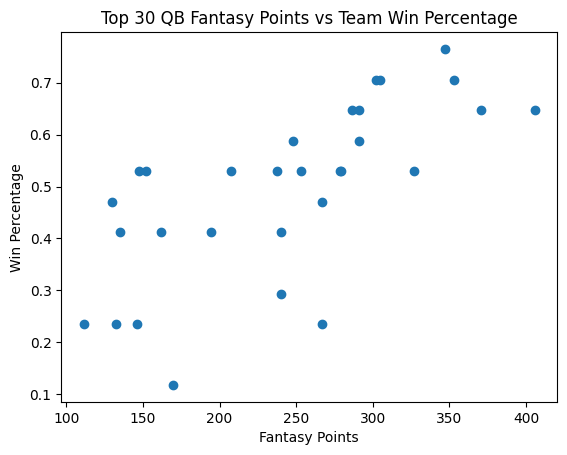

In [11]:
# Scatter plot between Fantasy Points and Win Percentage
plt.scatter(top_30_qb_stats_2023_df['Fantasy_Points'], top_30_qb_stats_2023_df['WIN_PCT'])
plt.title('Top 30 QB Fantasy Points vs Team Win Percentage')
plt.xlabel('Fantasy Points')
plt.ylabel('Win Percentage')
plt.show()

In getting the top 30 quarterback performances from the 2023 regular season, there is a moderately strong correlation (0.695475) between the team's `Win Percentage` and the quarterback's total `Fantasy Points`.

**Investigating RB vs Team Win Percentage Correlation**

In [12]:
top_80_rb_stats_2023_df = rb_stats_2023_df.nlargest(80, 'Fantasy_Points')
top_80_rb_win_correlation = top_80_rb_stats_2023_df[['Fantasy_Points', 'WIN_PCT']].corr()
top_80_rb_win_correlation

,Fantasy_Points,WIN_PCT
Fantasy_Points,1.000000,0.060511
WIN_PCT,0.060511,1.000000


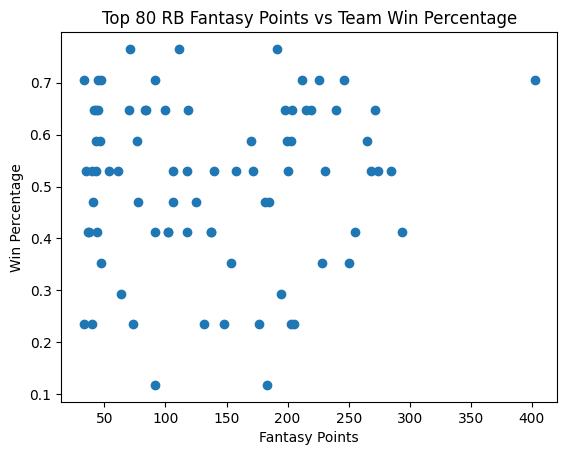

In [13]:
# Scatter plot between Fantasy Points and Win Percentage
plt.scatter(top_80_rb_stats_2023_df['Fantasy_Points'], top_80_rb_stats_2023_df['WIN_PCT'])
plt.title('Top 80 RB Fantasy Points vs Team Win Percentage')
plt.xlabel('Fantasy Points')
plt.ylabel('Win Percentage')
plt.show()

I elected to trim the RB dataframe to the top 80 runningbacks. This was where it broke off where players were still getting around ~30 touches (receptions + carries). 
This dataset shows their is no correlation on a runningback's fantasy points with their team's win percentage. 

**Investigating WR vs Team Win Percentage Correlation**

In [14]:
top_80_wr_stats_2023_df = wr_stats_2023_df.nlargest(80, 'Fantasy_Points')
top_80_wr_win_correlation = top_80_wr_stats_2023_df[['Fantasy_Points', 'WIN_PCT']].corr()
top_80_wr_win_correlation

,Fantasy_Points,WIN_PCT
Fantasy_Points,1.000000,0.219916
WIN_PCT,0.219916,1.000000


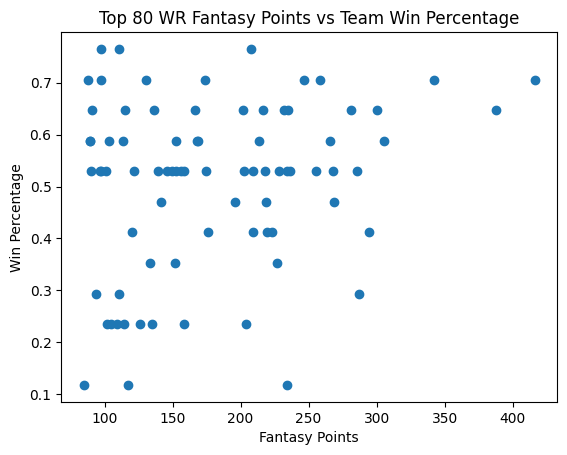

In [15]:
# Scatter plot between Fantasy Points and Win Percentage
plt.scatter(top_80_wr_stats_2023_df['Fantasy_Points'], top_80_wr_stats_2023_df['WIN_PCT'])
plt.title('Top 80 WR Fantasy Points vs Team Win Percentage')
plt.xlabel('Fantasy Points')
plt.ylabel('Win Percentage')
plt.show()

I also trimmed the WR dataframe to the top 80 wide receivers to find a range where players were still getting a reasonable amount of touches. 
This dataset showed a weak correlation on a wide receiver's fantasy points with their team's win percentage.

**Investigating TE vs Team Win Percentage Correlation**

In [17]:
top_40_te_stats_2023_df = te_stats_2023_df.nlargest(40, 'Fantasy_Points')
top_40_te_win_correlation = top_40_te_stats_2023_df[['Fantasy_Points', 'WIN_PCT']].corr()
top_40_te_win_correlation

,Fantasy_Points,WIN_PCT
Fantasy_Points,1.000000,0.251288
WIN_PCT,0.251288,1.000000


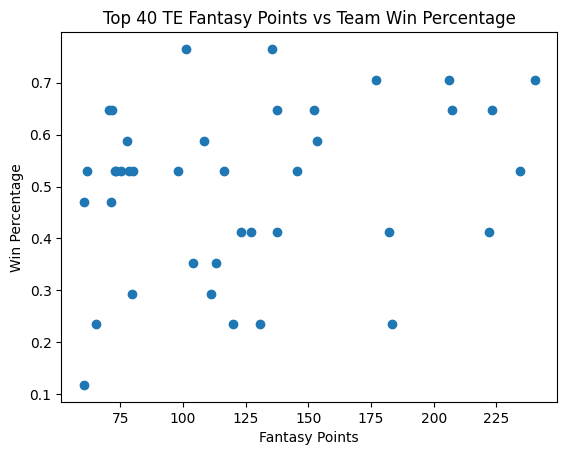

In [18]:
# Scatter plot between Fantasy Points and Win Percentage
plt.scatter(top_40_te_stats_2023_df['Fantasy_Points'], top_40_te_stats_2023_df['WIN_PCT'])
plt.title('Top 40 TE Fantasy Points vs Team Win Percentage')
plt.xlabel('Fantasy Points')
plt.ylabel('Win Percentage')
plt.show()

Trimmed TE dataframe to top 40 TEs. This had a weak correlation between a TE's fantasy points and their team's win percentage. 
